## 测试31.25ms

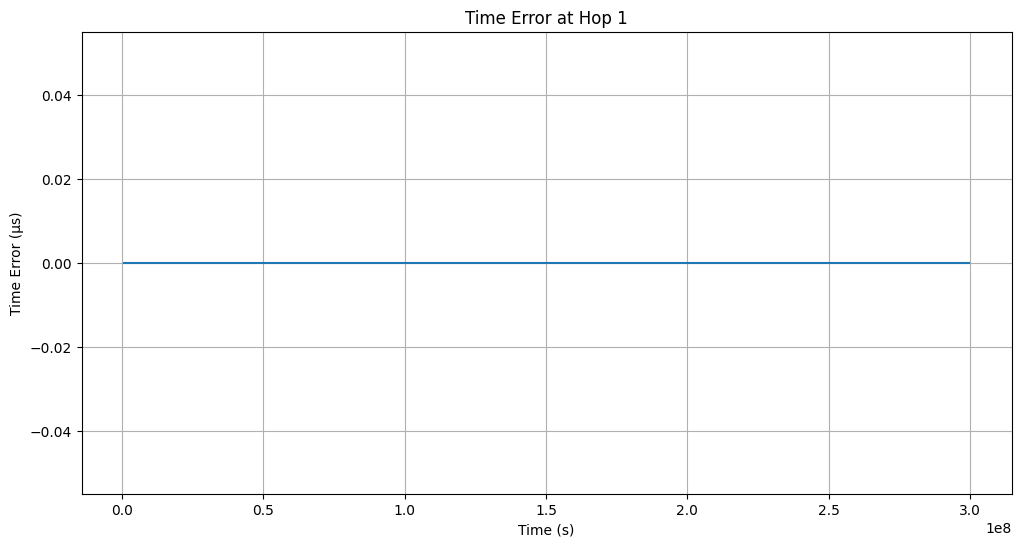

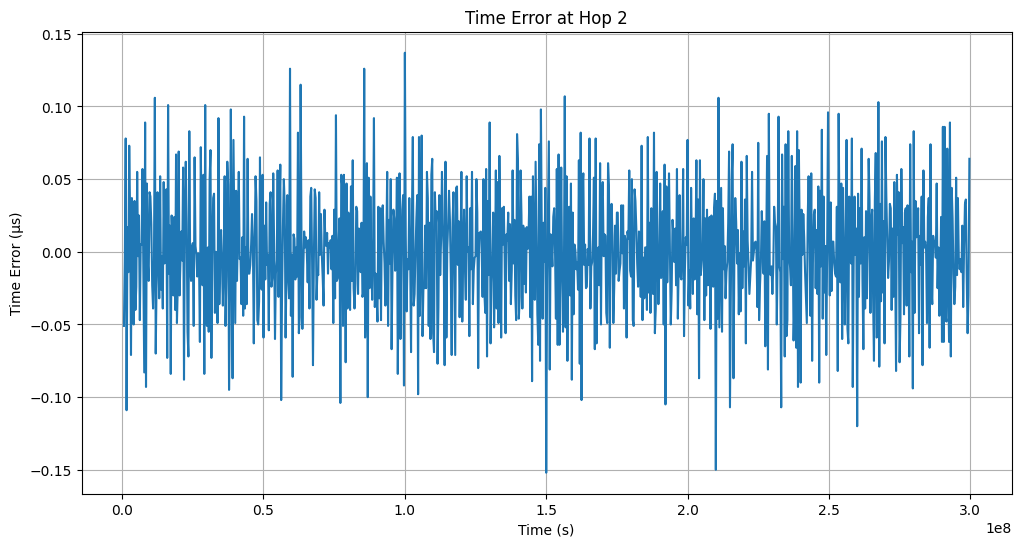

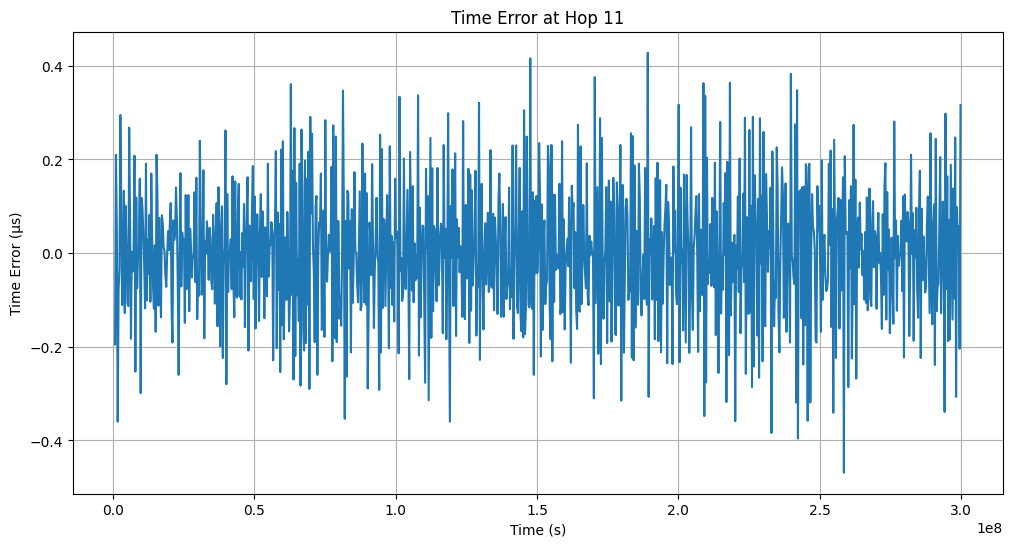

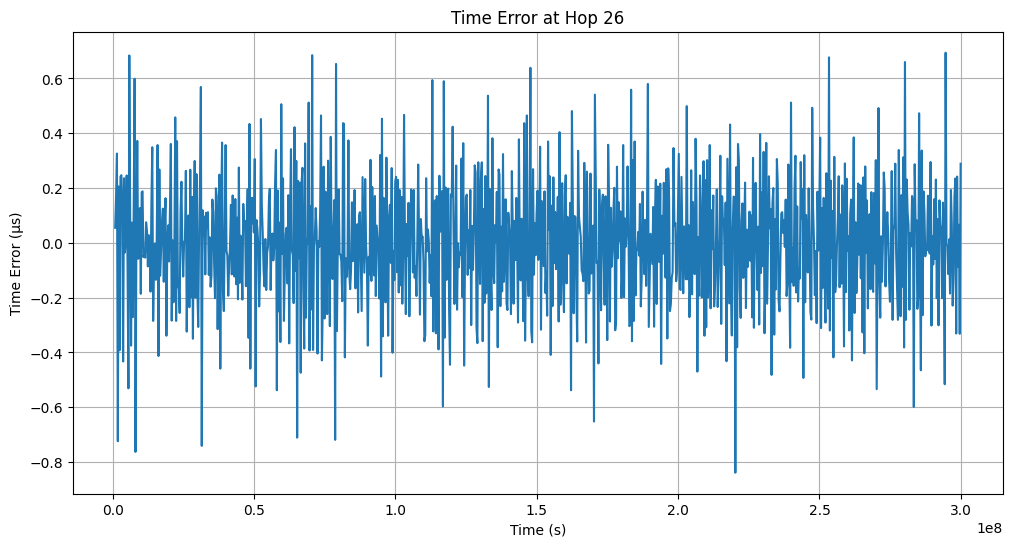

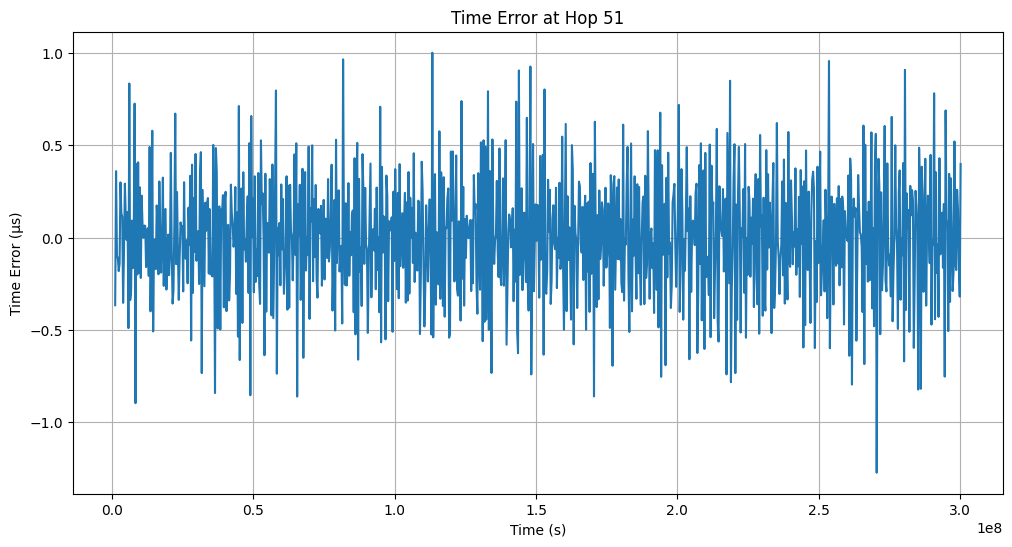

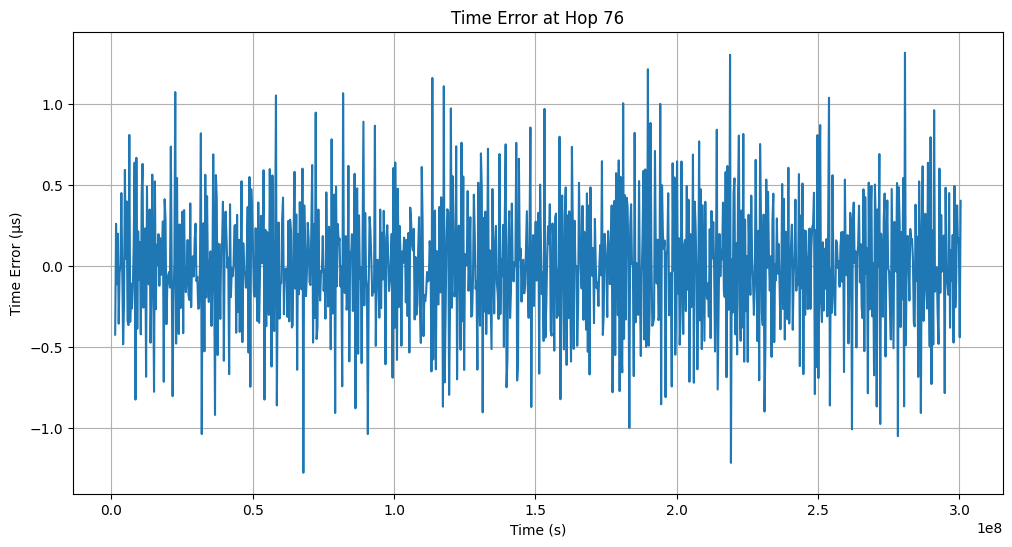

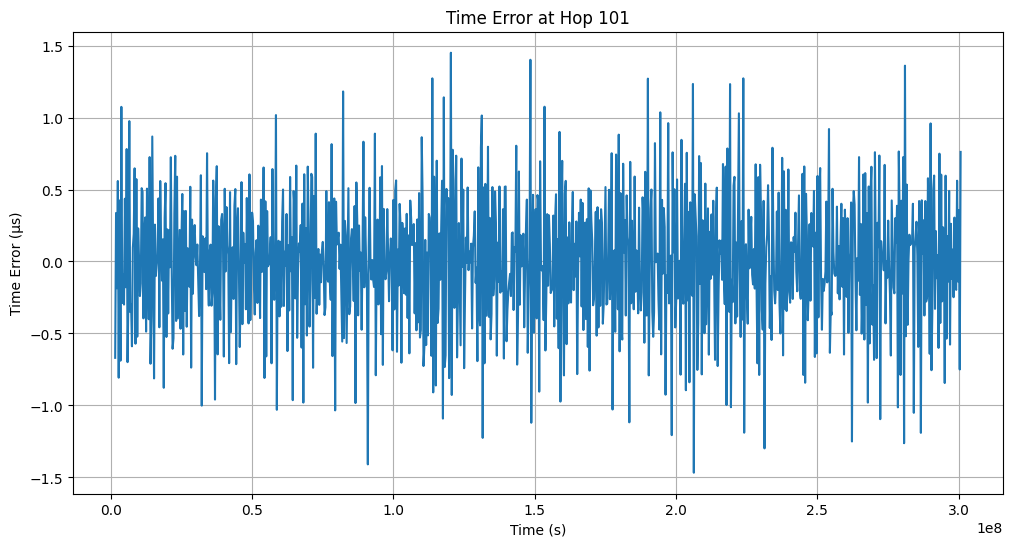

In [6]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/2/17 14:36
*  @Project :   pj_gptp_simulation
*  @Description :   Description
*  @FileName:   main_test5.py
**************************************
"""

import heapq
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import os
import csv

# 常量配置
NUM_NODES = 102  # 链式网络中的节点数
SYNC_INTERVAL = 0.03125  # 同步间隔 (31.25 ms)
# SYNC_INTERVAL = 1  # 同步间隔 (1s)
PHY_JITTER = 8e-9  # PHY抖动范围 (8 ns)
CLOCK_GRANULARITY = 8e-9  # 时钟粒度 (8 ns)
MAX_DRIFT_RATE = 10e-6  # 最大漂移率 (±10 ppm)
SIM_TIME = 30.0  # 仿真总时长 (秒)
# SIM_TIME = 240.0  # 仿真总时长 (秒)
PDELAY_INTERVAL = 1.0  # 传播延迟测量间隔 (1 s)
DRIFT_RATE_CHANGE = 1e-6  # 漂移率每秒变化范围 [0, 1] ppm/s


class Clock:
    def __init__(self, is_grandmaster=False):
        self.is_grandmaster = is_grandmaster
        # Grandmaster时钟漂移率设为0且不变化
        if self.is_grandmaster:
            self.drift_rate = 1.0
        else:
            self.drift_rate = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
        self.offset = 0.0  # 相对于主时钟的偏移
        self.time = 0.0  # 本地时间

    def update(self, delta_t):
        # 普通节点动态调整漂移率
        if not self.is_grandmaster:
            self.drift_rate += np.random.uniform(-DRIFT_RATE_CHANGE, DRIFT_RATE_CHANGE) * delta_t
            self.drift_rate = np.clip(self.drift_rate, -MAX_DRIFT_RATE, MAX_DRIFT_RATE)

        # 更新本地时间
        self.time += delta_t * (1 + self.drift_rate)
        return self.time

    def adjust(self, offset):
        # 调整本地时钟的偏移
        self.offset += offset
        self.time += offset


class Node:
    def __init__(self, node_id, is_grandmaster=False):
        self.id = node_id
        self.is_grandmaster = is_grandmaster
        # Grandmaster使用更精确的时钟模型
        self.clock = Clock(is_grandmaster=self.is_grandmaster)

        # Grandmaster的物理层参数更优
        self.residence_time = 0.5e-3 if is_grandmaster else 1e-3  # 驻留时间减半
        self.propagation_delay = 25e-9 if is_grandmaster else 50e-9  # 传播延迟减半

        self.last_sync_time = 0.0
        self.last_pdelay_time = 0.0
        self.asymmetry = 0.0
        self.rate_ratio = 1.0
        self.neighbor_rate_ratio = 1.0
        self.sync_errors = []
        self.time_errors = []

    def receive_sync(self, sync_time, correction_field):
        # Grandmaster的PHY抖动更小
        phy_jitter = 2e-9 if self.is_grandmaster else PHY_JITTER

        # 接收Sync消息时添加PHY抖动和时钟粒度
        actual_receive_time = sync_time + self.propagation_delay + \
                              np.random.uniform(0, phy_jitter) + \
                              np.random.uniform(0, CLOCK_GRANULARITY)

        # 计算本地时间与主时钟的偏差
        local_time = self.clock.time
        gm_time = sync_time + correction_field
        error = local_time - gm_time

        # 调整本地时钟（通过调整偏移量）
        self.clock.adjust(-error)

        # 记录时间误差（单位为秒）
        self.time_errors.append((self.clock.time, abs(error)))

        # 添加驻留时间并转发Sync消息
        forward_time = actual_receive_time + self.residence_time
        return forward_time

    def measure_pdelay(self, neighbor):
        # 发送Pdelay_Req消息
        t1 = self.clock.time
        t2 = neighbor.clock.time + np.random.uniform(0, PHY_JITTER)

        # 发送Pdelay_Resp消息
        t3 = neighbor.clock.time
        t4 = self.clock.time + np.random.uniform(0, PHY_JITTER)

        # 计算传播延迟（考虑非对称性）
        propagation_delay = ((t4 - t1) - self.neighbor_rate_ratio * (t3 - t2)) / 2
        self.propagation_delay = propagation_delay + self.asymmetry


class Network:
    def __init__(self):
        self.nodes = [Node(i, is_grandmaster=(i == 0)) for i in range(NUM_NODES)]
        self.grandmaster = self.nodes[0]
        self.event_queue = []
        self.current_time = 0.0
        self.event_counter = 0

    def schedule_event(self, time, callback, *args):
        heapq.heappush(self.event_queue, (time, self.event_counter, callback, args))
        self.event_counter += 1

    def run_simulation(self):
        self.schedule_event(0.0, self.send_sync, self.grandmaster)
        for i in range(1, NUM_NODES):
            self.schedule_event(0.0, self.measure_pdelay, self.nodes[i], self.nodes[i - 1])

        while self.event_queue and self.current_time < SIM_TIME:
            time, _, callback, args = heapq.heappop(self.event_queue)
            self.current_time = time
            callback(*args)

    def send_sync(self, node):
        # 主节点发送Sync消息
        sync_time = self.current_time
        correction_field = 0.0
        for i in range(1, NUM_NODES):
            # 消息逐跳传播
            forward_time = self.nodes[i].receive_sync(sync_time, correction_field)
            # 更新校正字段（包括率比和传播延迟误差）
            correction_field += self.nodes[i].propagation_delay * self.nodes[i].rate_ratio
            sync_time = forward_time

        # 安排下一次Sync消息
        self.schedule_event(self.current_time + SYNC_INTERVAL, self.send_sync, node)

    def measure_pdelay(self, node, neighbor):
        # 测量传播延迟
        node.measure_pdelay(neighbor)
        # 安排下一次测量
        self.schedule_event(self.current_time + PDELAY_INTERVAL, self.measure_pdelay, node, neighbor)

    def plot_results(self, hop):
        node = self.nodes[hop]
        times, errors = zip(*node.time_errors)

        times=times[2:]
        errors=errors[2:]

        times_tmp = convert_to_microseconds(times)
        errors_tmp = convert_to_microseconds(errors)

        errors_new = process_tuple(errors_tmp)

        save_tuple_to_csv(errors_new, filename=r'D:\06_engineering\03_analysis\pj_gptp_simulation\old_version\main_test5\output_data/data20250413v2.csv')

        plt.figure(figsize=(12, 6))
        # plt.plot(times, np.array(errors) * 1e6)  # 显示微秒级误差
        plt.plot(times_tmp, errors_new)  # 显示微秒级误差
        plt.xlabel('Time (s)')
        plt.ylabel('Time Error (μs)')
        plt.title(f'Time Error at Hop {hop}')
        plt.grid(True)

        # 使用 ScalarFormatter 来格式化 y 轴
        ax = plt.gca()
        ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

        plt.show()


def process_tuple(input_tuple):
    # 使用列表推导式处理每个元素
    processed_list = [round(x - 312500.0, 3) for x in input_tuple]
    # processed_list = [round(x - 10000000.0, 3) for x in input_tuple]
    # processed_list = [round(x, 3) for x in input_tuple]

    # 将处理后的列表转换回tuple并返回
    return tuple(processed_list)

def convert_to_microseconds(time_tuple):
    # 创建一个新的列表来存储转换后的值
    converted_list = []

    # 遍历输入元组中的每个元素
    for time in time_tuple:
        # 将秒转换为微秒，并保留三位小数
        microseconds = round(time * 10_000_000, 3)
        converted_list.append(microseconds)

    # 将列表转换为元组并返回
    return tuple(converted_list)

def save_tuple_to_csv(tuple_data, filename=r'D:\06_engineering\03_analysis\pj_gptp_simulation\old_version\main_test5\output_data/data20250413v2.csv'):
    # 检查文件是否存在
    file_exists = os.path.isfile(filename)

    # 读取现有数据（如果文件存在）
    existing_data = []
    if file_exists:
        with open(filename, 'r', newline='') as csvfile:
            reader = csv.reader(csvfile)
            existing_data = list(reader)

    # 找到第一个空列
    column_index = 0
    if existing_data:
        max_columns = max(len(row) for row in existing_data)
        for i in range(max_columns + 1):
            if all(i >= len(row) or row[i] == '' for row in existing_data):
                column_index = i
                break

    # 将 tuple 数据添加到正确的列
    for i, value in enumerate(tuple_data):
        row_index = i
        if row_index >= len(existing_data):
            existing_data.append([''] * (column_index + 1))
        while len(existing_data[row_index]) <= column_index:
            existing_data[row_index].append('')
        existing_data[row_index][column_index] = value

    # 写入数据到 CSV 文件
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(existing_data)

if __name__ == "__main__":
    network = Network()
    network.run_simulation()
    # for i in range(1,102):
    #     network.plot_results(i)
    network.plot_results(1)  # 查看第1跳结果
    network.plot_results(2)  # 查看第1跳结果
    network.plot_results(11)  # 查看第10跳结果
    network.plot_results(26)  # 查看第10跳结果
    network.plot_results(51)  # 查看第10跳结果
    network.plot_results(76)  # 查看第10跳结果
    network.plot_results(101)  # 查看最后一跳结果

得到 D:\06_engineering\03_analysis\pj_gptp_simulation\old_version\main_test5\output_data\data20250413v1.csv

好像两种对应的时间为8倍，所以按照8倍进行了仿真。得到v2.csv



## 测试1s

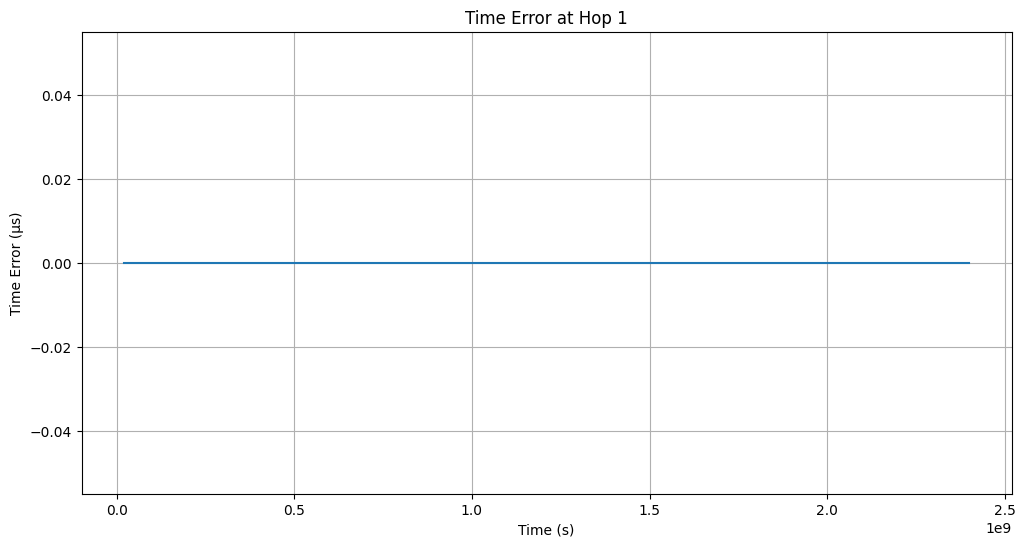

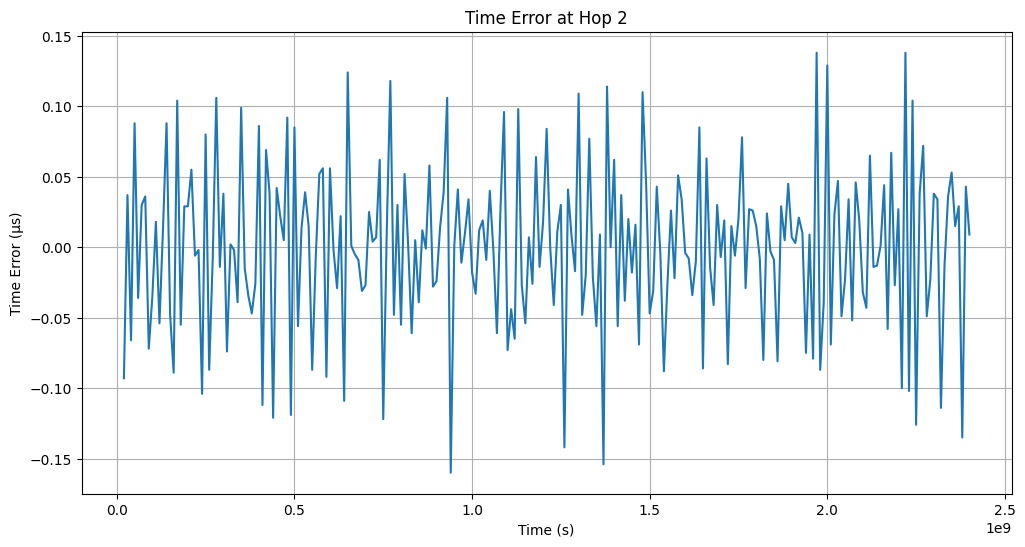

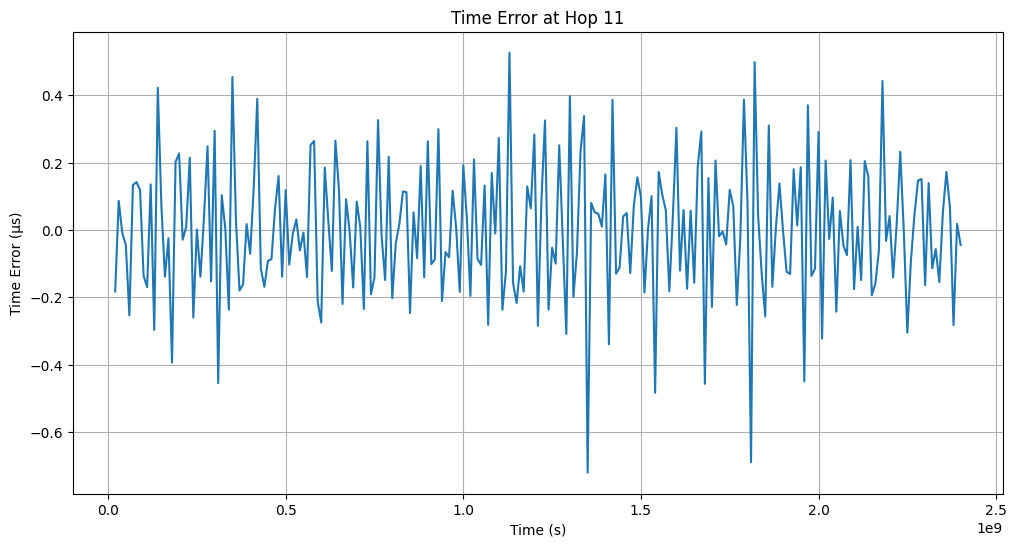

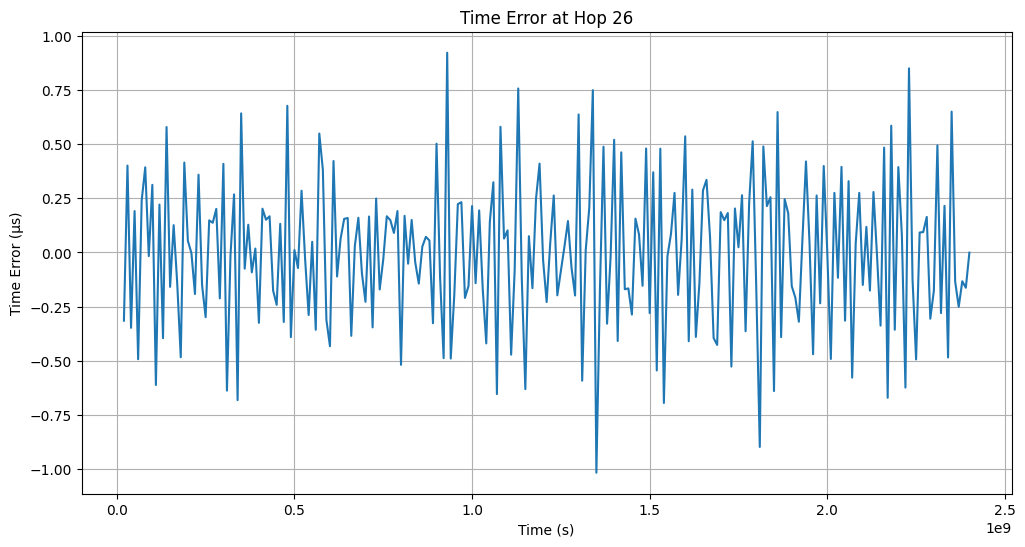

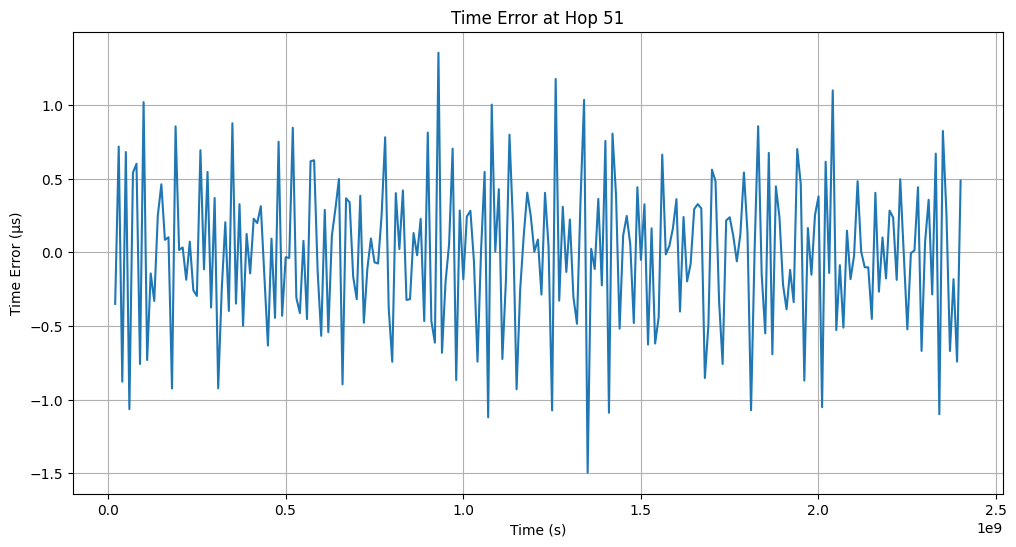

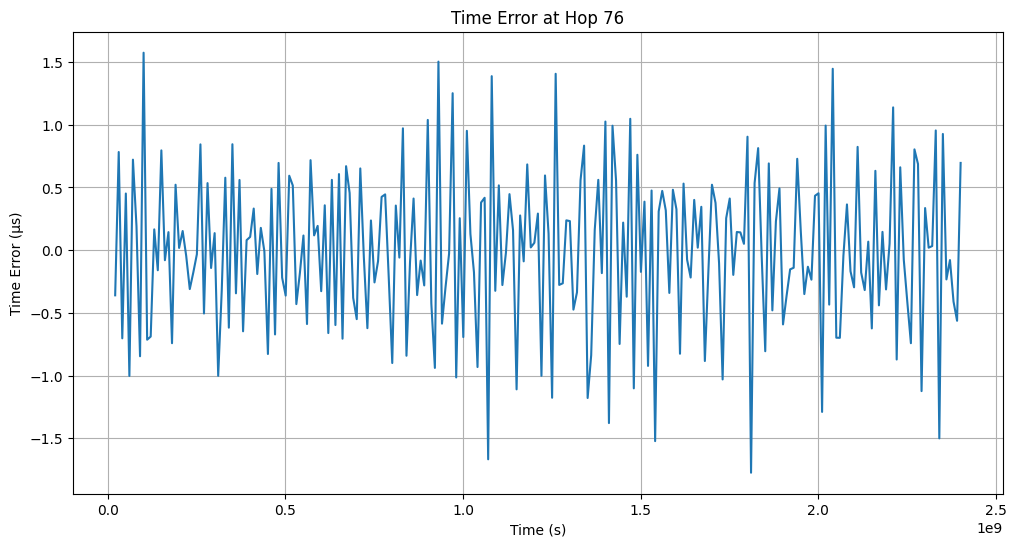

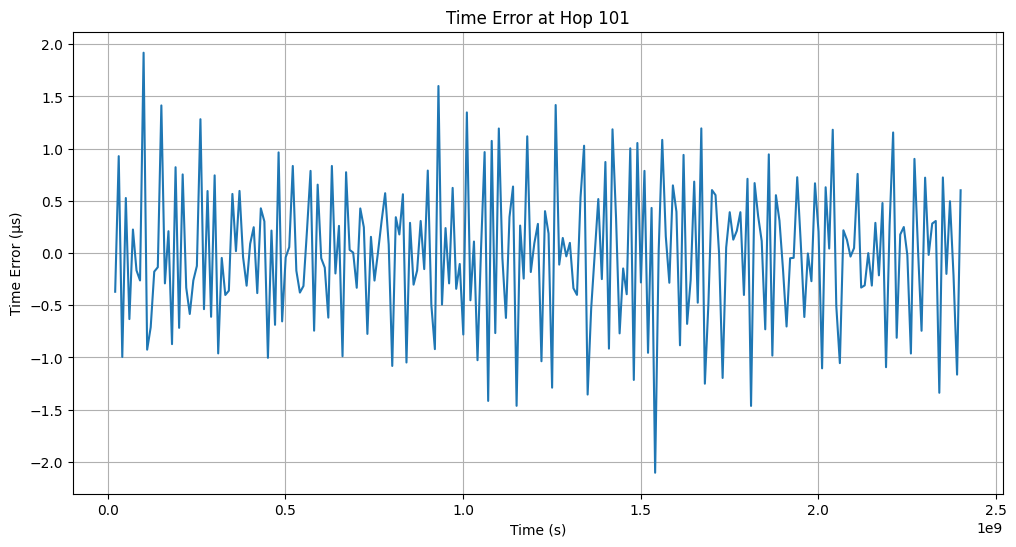

In [5]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/2/17 14:36
*  @Project :   pj_gptp_simulation
*  @Description :   Description
*  @FileName:   main_test5.py
**************************************
"""

import heapq
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import os
import csv

# 常量配置
NUM_NODES = 102  # 链式网络中的节点数
# SYNC_INTERVAL = 0.03125  # 同步间隔 (31.25 ms)
SYNC_INTERVAL = 1  # 同步间隔 (1s)
PHY_JITTER = 8e-9  # PHY抖动范围 (8 ns)
CLOCK_GRANULARITY = 8e-9  # 时钟粒度 (8 ns)
MAX_DRIFT_RATE = 10e-6  # 最大漂移率 (±10 ppm)
# SIM_TIME = 60.0  # 仿真总时长 (秒)
SIM_TIME = 240.0  # 仿真总时长 (秒)
PDELAY_INTERVAL = 1.0  # 传播延迟测量间隔 (1 s)
DRIFT_RATE_CHANGE = 1e-6  # 漂移率每秒变化范围 [0, 1] ppm/s


class Clock:
    def __init__(self, is_grandmaster=False):
        self.is_grandmaster = is_grandmaster
        # Grandmaster时钟漂移率设为0且不变化
        if self.is_grandmaster:
            self.drift_rate = 1.0
        else:
            self.drift_rate = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
        self.offset = 0.0  # 相对于主时钟的偏移
        self.time = 0.0  # 本地时间

    def update(self, delta_t):
        # 普通节点动态调整漂移率
        if not self.is_grandmaster:
            self.drift_rate += np.random.uniform(-DRIFT_RATE_CHANGE, DRIFT_RATE_CHANGE) * delta_t
            self.drift_rate = np.clip(self.drift_rate, -MAX_DRIFT_RATE, MAX_DRIFT_RATE)

        # 更新本地时间
        self.time += delta_t * (1 + self.drift_rate)
        return self.time

    def adjust(self, offset):
        # 调整本地时钟的偏移
        self.offset += offset
        self.time += offset


class Node:
    def __init__(self, node_id, is_grandmaster=False):
        self.id = node_id
        self.is_grandmaster = is_grandmaster
        # Grandmaster使用更精确的时钟模型
        self.clock = Clock(is_grandmaster=self.is_grandmaster)

        # Grandmaster的物理层参数更优
        self.residence_time = 0.5e-3 if is_grandmaster else 1e-3  # 驻留时间减半
        self.propagation_delay = 25e-9 if is_grandmaster else 50e-9  # 传播延迟减半

        self.last_sync_time = 0.0
        self.last_pdelay_time = 0.0
        self.asymmetry = 0.0
        self.rate_ratio = 1.0
        self.neighbor_rate_ratio = 1.0
        self.sync_errors = []
        self.time_errors = []

    def receive_sync(self, sync_time, correction_field):
        # Grandmaster的PHY抖动更小
        phy_jitter = 2e-9 if self.is_grandmaster else PHY_JITTER

        # 接收Sync消息时添加PHY抖动和时钟粒度
        actual_receive_time = sync_time + self.propagation_delay + \
                              np.random.uniform(0, phy_jitter) + \
                              np.random.uniform(0, CLOCK_GRANULARITY)

        # 计算本地时间与主时钟的偏差
        local_time = self.clock.time
        gm_time = sync_time + correction_field
        error = local_time - gm_time

        # 调整本地时钟（通过调整偏移量）
        self.clock.adjust(-error)

        # 记录时间误差（单位为秒）
        self.time_errors.append((self.clock.time, abs(error)))

        # 添加驻留时间并转发Sync消息
        forward_time = actual_receive_time + self.residence_time
        return forward_time

    def measure_pdelay(self, neighbor):
        # 发送Pdelay_Req消息
        t1 = self.clock.time
        t2 = neighbor.clock.time + np.random.uniform(0, PHY_JITTER)

        # 发送Pdelay_Resp消息
        t3 = neighbor.clock.time
        t4 = self.clock.time + np.random.uniform(0, PHY_JITTER)

        # 计算传播延迟（考虑非对称性）
        propagation_delay = ((t4 - t1) - self.neighbor_rate_ratio * (t3 - t2)) / 2
        self.propagation_delay = propagation_delay + self.asymmetry


class Network:
    def __init__(self):
        self.nodes = [Node(i, is_grandmaster=(i == 0)) for i in range(NUM_NODES)]
        self.grandmaster = self.nodes[0]
        self.event_queue = []
        self.current_time = 0.0
        self.event_counter = 0

    def schedule_event(self, time, callback, *args):
        heapq.heappush(self.event_queue, (time, self.event_counter, callback, args))
        self.event_counter += 1

    def run_simulation(self):
        self.schedule_event(0.0, self.send_sync, self.grandmaster)
        for i in range(1, NUM_NODES):
            self.schedule_event(0.0, self.measure_pdelay, self.nodes[i], self.nodes[i - 1])

        while self.event_queue and self.current_time < SIM_TIME:
            time, _, callback, args = heapq.heappop(self.event_queue)
            self.current_time = time
            callback(*args)

    def send_sync(self, node):
        # 主节点发送Sync消息
        sync_time = self.current_time
        correction_field = 0.0
        for i in range(1, NUM_NODES):
            # 消息逐跳传播
            forward_time = self.nodes[i].receive_sync(sync_time, correction_field)
            # 更新校正字段（包括率比和传播延迟误差）
            correction_field += self.nodes[i].propagation_delay * self.nodes[i].rate_ratio
            sync_time = forward_time

        # 安排下一次Sync消息
        self.schedule_event(self.current_time + SYNC_INTERVAL, self.send_sync, node)

    def measure_pdelay(self, node, neighbor):
        # 测量传播延迟
        node.measure_pdelay(neighbor)
        # 安排下一次测量
        self.schedule_event(self.current_time + PDELAY_INTERVAL, self.measure_pdelay, node, neighbor)

    def plot_results(self, hop):
        node = self.nodes[hop]
        times, errors = zip(*node.time_errors)

        times=times[2:]
        errors=errors[2:]

        times_tmp = convert_to_microseconds(times)
        errors_tmp = convert_to_microseconds(errors)

        errors_new = process_tuple(errors_tmp)

        save_tuple_to_csv(errors_new, filename=r'D:\06_engineering\03_analysis\pj_gptp_simulation\old_version\main_test5\output_data/data20250413v1_1s.csv')

        plt.figure(figsize=(12, 6))
        # plt.plot(times, np.array(errors) * 1e6)  # 显示微秒级误差
        plt.plot(times_tmp, errors_new)  # 显示微秒级误差
        plt.xlabel('Time (s)')
        plt.ylabel('Time Error (μs)')
        plt.title(f'Time Error at Hop {hop}')
        plt.grid(True)

        # 使用 ScalarFormatter 来格式化 y 轴
        ax = plt.gca()
        ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

        plt.show()


def process_tuple(input_tuple):
    # 使用列表推导式处理每个元素
    # processed_list = [round(x - 312500.0, 3) for x in input_tuple]
    processed_list = [round(x - 10000000.0, 3) for x in input_tuple]
    # processed_list = [round(x, 3) for x in input_tuple]

    # 将处理后的列表转换回tuple并返回
    return tuple(processed_list)

def convert_to_microseconds(time_tuple):
    # 创建一个新的列表来存储转换后的值
    converted_list = []

    # 遍历输入元组中的每个元素
    for time in time_tuple:
        # 将秒转换为微秒，并保留三位小数
        microseconds = round(time * 10_000_000, 3)
        converted_list.append(microseconds)

    # 将列表转换为元组并返回
    return tuple(converted_list)

def save_tuple_to_csv(tuple_data, filename=r'D:\06_engineering\03_analysis\pj_gptp_simulation\old_version\main_test5\output_data/data20250413v1_1s.csv'):
    # 检查文件是否存在
    file_exists = os.path.isfile(filename)

    # 读取现有数据（如果文件存在）
    existing_data = []
    if file_exists:
        with open(filename, 'r', newline='') as csvfile:
            reader = csv.reader(csvfile)
            existing_data = list(reader)

    # 找到第一个空列
    column_index = 0
    if existing_data:
        max_columns = max(len(row) for row in existing_data)
        for i in range(max_columns + 1):
            if all(i >= len(row) or row[i] == '' for row in existing_data):
                column_index = i
                break

    # 将 tuple 数据添加到正确的列
    for i, value in enumerate(tuple_data):
        row_index = i
        if row_index >= len(existing_data):
            existing_data.append([''] * (column_index + 1))
        while len(existing_data[row_index]) <= column_index:
            existing_data[row_index].append('')
        existing_data[row_index][column_index] = value

    # 写入数据到 CSV 文件
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(existing_data)

if __name__ == "__main__":
    network = Network()
    network.run_simulation()
    # for i in range(1,102):
    #     network.plot_results(i)
    network.plot_results(1)  # 查看第1跳结果
    network.plot_results(2)  # 查看第1跳结果
    network.plot_results(11)  # 查看第10跳结果
    network.plot_results(26)  # 查看第10跳结果
    network.plot_results(51)  # 查看第10跳结果
    network.plot_results(76)  # 查看第10跳结果
    network.plot_results(101)  # 查看最后一跳结果

感觉有问题，继续回溯maintest4